In [24]:
import sqlite3
import csv
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%env KMP_DUPLICATE_LIB_OK=TRUE

env: KMP_DUPLICATE_LIB_OK=TRUE


In [29]:
def read_sales_csv(filename):
    sales = []
    with open(filename) as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            date = datetime.strptime(row['date'], '%m/%d/%y')
            sales.append({'date': date,
                     'days_ago': (datetime.now() - date).days,
                     'account_number': row['account_number'],
                     'price': int(row['price'])})
    return sales

conn = sqlite3.connect('file:NW_Central_OKC_w_bldg_details.db?mode=ro', uri=True)
c = conn.cursor()

sales = read_sales_csv('sales_list_2019.csv')
#sales = sales + read_sales_csv('sales_list_2018.csv')
#sales = sales + read_sales_csv('sales_list_2017.csv')

Now let's load the data into DataFrames. We have two tables we're using, one for properties/parcels and one for buildings. So what we'll do is pull out some data about the buildings, sum it up (as some properties have more than 1 building), and add it to the property DF.

In [30]:
combined_df = pd.read_sql_query("SELECT * FROM realproperty INNER JOIN buildings ON realproperty.id = buildings.local_property_id;", conn)
rp_df = pd.read_sql_query("SELECT * FROM realproperty WHERE property_type = 'Residential'", conn)
rp_df = rp_df.set_index('account_number')

# Get data about the buildings for each parcel. We'll sum up the data for now
# (in cases where there's >1 building on the property)
rp_df['sqft_sum'] = combined_df.groupby(['account_number'])['sq_ft'].sum()
rp_df['bed_sum'] = combined_df.replace(-1,0).groupby(['account_number'])['bedrooms'].sum()
rp_df['bath_sum'] = combined_df.replace(-1,0).groupby(['account_number'])['full_bathrooms'].sum() +\
    (combined_df.replace(-1,0).groupby(['account_number'])['three_quarters_bathrooms'].sum() * 0.75) +\
    (combined_df.replace(-1,0).groupby(['account_number'])['half_bathrooms'].sum() * 0.5)
rp_df['room_sum'] = combined_df.replace(-1,0).groupby(['account_number'])['total_rooms'].sum()
rp_df['main_bldg_sqft'] = combined_df.groupby(['account_number'])['sq_ft'].max()
rp_df['year_built'] = combined_df[combined_df.year_built != -1].groupby(['account_number'])['year_built'].mean()
rp_df['bldg_age'] = pd.datetime.now().year - rp_df['year_built']

display(rp_df)

,id,propertyid,property_type,location,building_name_occupant,city,owner_name_1,owner_name_2,billing_address_1,billing_address_2,city_state_zip,quarter_section,parent_acct,tax_district,school_system,land_size,lot_width,lot_depth,land_value,quarter_section_description,subdivision,block,lot,legal_description,sqft_sum,bed_sum,bath_sum,room_sum,main_bldg_sqft,year_built,bldg_age
account_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
R049810025,1,130116,Residential,400 NW 43RD ST,,OKLAHOMA CITY,YOUNGS STEVEN ROGERS,TURLEY ALLISON,400 NW 43RD ST,,"OKLAHOMA CITY, OK 73118-8221",2661,,TXD 200,Oklahoma City #89,13068.0,None,None,52721,Sect 16-T12N-R3W Qtr NE,EDGEMERE TERRACE,001,001,EDGEMERE TERRACE 001 001,1824.0,3.0,2.00,7.0,1824.0,1951.0,68.0
R049810050,3,130117,Residential,408 NW 43RD ST,,OKLAHOMA CITY,JUNGMAN TIMOTHY WILLIAM & JULIE LYN,,408 NW 43RD ST,,"OKLAHOMA CITY, OK 73118-8221",2661,,TXD 200,Oklahoma City #89,9147.6,None,None,45900,Sect 16-T12N-R3W Qtr NE,EDGEMERE TERRACE,001,002,EDGEMERE TERRACE 001 002,2677.0,3.0,2.50,6.0,2677.0,1951.0,68.0
R049480080,6,130504,Residential,1009 NW 42ND ST,,OKLAHOMA CITY,SPEARS KENNETH L & REGINA,,210 NW 10TH ST,,"OKLAHOMA CITY, OK 73103-3902",2663,,TXD 200,Oklahoma City #89,7405.2,None,None,71460,Sect 16-T12N-R3W Qtr SW,CROWN HEIGHTS ADD,001,004,CROWN HEIGHTS ADD 001 004,1961.0,2.0,2.00,9.0,1961.0,1939.0,80.0
R049640005,7,131004,Residential,5021 N WALKER AVE,,OKLAHOMA CITY,CRISP STEVE & ANGIE,,5021 N WALKER,,"OKLAHOMA CITY, OK 73118",2664,,TXD 200,Oklahoma City #89,9147.6,None,None,48230,Sect 16-T12N-R3W Qtr NW,DOUGLAS PLACE ADD,001,000,DOUGLAS PLACE ADD 001 000 LOTS 1 & 2,1352.0,3.0,1.50,6.0,1352.0,1951.0,68.0
R049640010,8,131005,Residential,504 NW 50TH ST,,OKLAHOMA CITY,DICKSON JERRY ROBERT,,504 NW 50TH ST,,"OKLAHOMA CITY, OK 73118-6204",2664,,TXD 200,Oklahoma City #89,6969.6,None,None,37100,Sect 16-T12N-R3W Qtr NW,DOUGLAS PLACE ADD,001,000,DOUGLAS PLACE ADD 001 000 LOTS 3 & 4,1386.0,3.0,1.50,6.0,1386.0,1951.0,68.0
R049640015,9,131006,Residential,508 NW 50TH ST,,OKLAHOMA CITY,GARRETT & COMPANY LLC,,9701 BROADWAY EXT,,"OKLAHOMA CITY, OK 73114-6316",2664,,TXD 200,Oklahoma City #89,6969.6,None,None,37100,Sect 16-T12N-R3W Qtr NW,DOUGLAS PLACE ADD,001,000,DOUGLAS PLACE ADD 001 000 LOTS 5 & 6,1092.0,2.0,1.00,4.0,1092.0,1950.0,69.0
R049810100,10,130119,Residential,418 NW 43RD ST,,OKLAHOMA CITY,BRADEN THOMAS GARY & BEVERLY JOAN,REVOCABLE LIVING TRUST,418 NW 43RD ST,,"OKLAHOMA CITY, OK 73118-8221",2661,,TXD 200,Oklahoma City #89,9147.6,None,None,45900,Sect 16-T12N-R3W Qtr NE,EDGEMERE TERRACE,001,004,EDGEMERE TERRACE 001 004,2047.0,2.0,2.00,7.0,2047.0,1951.0,68.0
R049640020,12,131007,Residential,512 NW 50TH ST,,OKLAHOMA CITY,HALPIN JEFFREY J,,512 NW 50TH ST,,"OKLAHOMA CITY, OK 73118-6204",2664,,TXD 200,Oklahoma City #89,6969.6,None,None,37100,Sect 16-T12N-R3W Qtr NW,DOUGLAS PLACE ADD,001,000,DOUGLAS PLACE ADD 001 000 LOTS 7 & 8,1038.0,2.0,1.00,4.0,1038.0,1950.0,69.0
R049480100,13,130505,Residential,1005 NW 42ND ST,,OKLAHOMA CITY,DK INC,,C/O KENNETH L SPEARS,PO BOX 687,"OKLAHOMA CITY, OK 73101",2663,,TXD 200,Oklahoma City #89,7405.2,None,None,71460,Sect 16-T12N-R3W Qtr SW,CROWN HEIGHTS ADD,001,005,CROWN HEIGHTS ADD 001 005,1660.0,2.0,2.00,8.0,1660.0,1947.0,72.0


Now let's add more features for the main building. To do this we'll create a new DataFrame containing the features of the largest building on each property. While most single-family properties only have one building, we do need to consider that some will have multiple.

In [31]:
# we want 26584 not 26631
idx = combined_df.groupby(['account_number'])['sq_ft'].transform(max) == combined_df['sq_ft']
pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 100)
combined_df2 = combined_df[idx]


# now that we have the ones with largest sq ft on the parcel, let's weed out duplicates (where there are
# multiple bldgs with identical sq ft)
idx = combined_df2.groupby(['account_number'])['bldg_id'].transform(max) == combined_df2['bldg_id']
combined_df2 = combined_df2[idx]
combined_df2 = combined_df2.set_index(['account_number'])
combined_df2

,id,propertyid,property_type,location,building_name_occupant,city,owner_name_1,owner_name_2,billing_address_1,billing_address_2,city_state_zip,quarter_section,parent_acct,tax_district,school_system,land_size,lot_width,lot_depth,land_value,quarter_section_description,subdivision,block,lot,legal_description,id,local_property_id,bldg_id,vacant_or_improved,bldg_description,year_built,sq_ft,number_stories,remodel_year,building_name,alt_land_use_desc,quality_description,frame_description,foundation_description,exterior,roof_type,roof_cover,avg_floor_height,percent_sprinkled,total_rooms,bedrooms,full_bathrooms,three_quarters_bathrooms,half_bathrooms,hvac_type,physical_condition,number_res_units,number_comm_units
account_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
R049810025,1,130116,Residential,400 NW 43RD ST,,OKLAHOMA CITY,YOUNGS STEVEN ROGERS,TURLEY ALLISON,400 NW 43RD ST,,"OKLAHOMA CITY, OK 73118-8221",2661,,TXD 200,Oklahoma City #89,13068.0,None,None,52721,Sect 16-T12N-R3W Qtr NE,EDGEMERE TERRACE,001,001,EDGEMERE TERRACE 001 001,1,1,1,Improved,Ranch 1 Story,1951,1824,1.0,2014,,Residential Improvement,Fair,,Conventional,Frame Masonry Veneer,Hip,Composition Shingle,8,0,7,3,2,0,0,Central Air to Air,Average,1,0
R049480020,2,130501,Commercial,4300 N WESTERN AVE,PARKING FOR BARREL AND DRUM ROOM,OKLAHOMA CITY,VHG PROPERTY INTERESTS LLC,,PO BOX 18877,,"OKLAHOMA CITY, OK 73154",2663,,TXD 200,Oklahoma City #89,10454.4,None,None,124585,Sect 16-T12N-R3W Qtr SW,CROWN HEIGHTS ADD,001,000,CROWN HEIGHTS ADD 001 000 S89.5FT LOTS 1 & 2,2,2,1,Improved,Parking Lot,2005,0,1.0,-1,PARKING FOR BARREL AND DRUM ROOM,Commercial Improvement,None,None,,,,,8,0,-1,-1,0,0,0,None,Poor,0,0
R049810050,3,130117,Residential,408 NW 43RD ST,,OKLAHOMA CITY,JUNGMAN TIMOTHY WILLIAM & JULIE LYN,,408 NW 43RD ST,,"OKLAHOMA CITY, OK 73118-8221",2661,,TXD 200,Oklahoma City #89,9147.6,None,None,45900,Sect 16-T12N-R3W Qtr NE,EDGEMERE TERRACE,001,002,EDGEMERE TERRACE 001 002,3,3,1,Improved,Split Level,1951,2677,1.0,2010,,Residential Improvement,Fair,,Conventional,Frame Masonry Veneer,Hip,Composition Shingle,8,0,6,3,2,0,1,Central Air to Air,Average,1,0
R049480040,4,130502,Commercial,4308 N WESTERN AVE,BARREL,OKLAHOMA CITY,VHG PROPERTY INTERESTS LLC,,PO BOX 18877,,"OKLAHOMA CITY, OK 73154-0877",2663,,TXD 200,Oklahoma City #89,13068.0,None,None,79000,Sect 16-T12N-R3W Qtr SW,CROWN HEIGHTS ADD,001,000,CROWN HEIGHTS ADD 001 000 N50FT LOTS 1 & 2 & A...,4,4,1,Improved,Restaurant,1935,4738,1.0,2005,BARREL,Commercial Improvement,Fair,Masonry,,,Flat,,12,0,-1,-1,0,0,0,Complete HVAC,Good,0,1
R056050500,5,131543,Commercial,1112 NW 50TH ST,QUEEN BEE/ PRAIRIE ARTS/ BOARD UP,OKLAHOMA CITY,FOREST SIDING SUPPLY LLC,,1117 NW 50TH ST,,"OKLAHOMA CITY, OK 73118",2665,,TXD 200,Oklahoma City #89,15681.6,None,None,78000,Sect 17-T12N-R3W Qtr NE,ISLE VIEW SUB ADD,001,000,ISLE VIEW SUB ADD 001 000 LOTS 7 THRU 10,5,5,1,Improved,Ranch 1 Story,1925,1708,1.0,2000,QUEEN BEE/ PRAIRIE ARTS/ BOARD UP,Commercial Improvement,Average,,Slab,Frame Masonry Veneer,Gable,Composition Shingle,8,0,0,0,0,0,0,Central Air to Air,Average,1,0
R049480080,6,130504,Residential,1009 NW 42ND ST,,OKLAHOMA CITY,SPEARS KENNETH L & REGINA,,210 NW 10TH ST,,"OKLAHOMA CITY, OK 73103-3902",2663,,TXD 200,Oklahoma City #89,7405.2,None,None,71460,Sect 16-T12N-R3W Qtr SW,CROWN HEIGHTS ADD,001,004,CROWN HEIGHTS ADD 001 004,7,6,1,Improved,Duplex One Story,1939,1961,1.0,1977,,Residential Improvement,Fair,,Conventional,Frame Masonry Veneer,Hip,Composition Shingle,8,0,9,2,2,0,0,Central Air to Air,Average,2,0
R049640005,7,131004,Residential,5021 N WALKER AVE,,OKLAHOMA CITY,CRISP STEVE & ANGIE,,5021 N WALKER,,"OKLAHOMA CITY, OK 73118",2664,,TXD 200,Oklahoma City #89,9147.6,None,None,48230,Sect 16-T12N-R3W Qtr NW,DOUGLAS PLACE ADD,001,000,DOUGLAS PLACE ADD 001 000 LOTS 1 & 2,8,7,1,Improved,Ranch 1 Story,1951,1352,1.0,1997,,Residential Improvement,Fair,,Conventional,Frame Masonry Veneer,Gable,Composition Shingle,8,0,6,3,1,0,1,Central Air to 

Now we have the features for the largest building on each parcel. Let's add some of these to combined_df (like we did above).

In [32]:
print(len(rp_df))
print(len(combined_df2))
#print(combined_df2.groupby(['account_number'])['bldg_description'])
rp_df['main_bldg_description'] = combined_df2['bldg_description']
rp_df['main_bldg_hvac'] = combined_df2['hvac_type']
rp_df['main_bldg_quality'] = combined_df2['quality_description']
# Floor height is not worth using as it is listed as 8 on the vast majority of residential properties
rp_df['main_bldg_exterior'] = combined_df2['exterior']
rp_df['main_bldg_roof'] = combined_df2['roof_type']
rp_df['main_bldg_year'] = combined_df2['year_built']
rp_df['main_bldg_effective_year'] = combined_df2[['year_built', 'remodel_year']].max(axis=1) # remodel year, else built year
rp_df

21978
26584


,id,propertyid,property_type,location,building_name_occupant,city,owner_name_1,owner_name_2,billing_address_1,billing_address_2,city_state_zip,quarter_section,parent_acct,tax_district,school_system,land_size,lot_width,lot_depth,land_value,quarter_section_description,subdivision,block,lot,legal_description,sqft_sum,bed_sum,bath_sum,room_sum,main_bldg_sqft,year_built,bldg_age,main_bldg_description,main_bldg_hvac,main_bldg_quality,main_bldg_exterior,main_bldg_roof,main_bldg_year,main_bldg_effective_year
account_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
R049810025,1,130116,Residential,400 NW 43RD ST,,OKLAHOMA CITY,YOUNGS STEVEN ROGERS,TURLEY ALLISON,400 NW 43RD ST,,"OKLAHOMA CITY, OK 73118-8221",2661,,TXD 200,Oklahoma City #89,13068.0,None,None,52721,Sect 16-T12N-R3W Qtr NE,EDGEMERE TERRACE,001,001,EDGEMERE TERRACE 001 001,1824.0,3.0,2.00,7.0,1824.0,1951.0,68.0,Ranch 1 Story,Central Air to Air,Fair,Frame Masonry Veneer,Hip,1951.0,2014.0
R049810050,3,130117,Residential,408 NW 43RD ST,,OKLAHOMA CITY,JUNGMAN TIMOTHY WILLIAM & JULIE LYN,,408 NW 43RD ST,,"OKLAHOMA CITY, OK 73118-8221",2661,,TXD 200,Oklahoma City #89,9147.6,None,None,45900,Sect 16-T12N-R3W Qtr NE,EDGEMERE TERRACE,001,002,EDGEMERE TERRACE 001 002,2677.0,3.0,2.50,6.0,2677.0,1951.0,68.0,Split Level,Central Air to Air,Fair,Frame Masonry Veneer,Hip,1951.0,2010.0
R049480080,6,130504,Residential,1009 NW 42ND ST,,OKLAHOMA CITY,SPEARS KENNETH L & REGINA,,210 NW 10TH ST,,"OKLAHOMA CITY, OK 73103-3902",2663,,TXD 200,Oklahoma City #89,7405.2,None,None,71460,Sect 16-T12N-R3W Qtr SW,CROWN HEIGHTS ADD,001,004,CROWN HEIGHTS ADD 001 004,1961.0,2.0,2.00,9.0,1961.0,1939.0,80.0,Duplex One Story,Central Air to Air,Fair,Frame Masonry Veneer,Hip,1939.0,1977.0
R049640005,7,131004,Residential,5021 N WALKER AVE,,OKLAHOMA CITY,CRISP STEVE & ANGIE,,5021 N WALKER,,"OKLAHOMA CITY, OK 73118",2664,,TXD 200,Oklahoma City #89,9147.6,None,None,48230,Sect 16-T12N-R3W Qtr NW,DOUGLAS PLACE ADD,001,000,DOUGLAS PLACE ADD 001 000 LOTS 1 & 2,1352.0,3.0,1.50,6.0,1352.0,1951.0,68.0,Ranch 1 Story,Central Air to Air,Fair,Frame Masonry Veneer,Gable,1951.0,1997.0
R049640010,8,131005,Residential,504 NW 50TH ST,,OKLAHOMA CITY,DICKSON JERRY ROBERT,,504 NW 50TH ST,,"OKLAHOMA CITY, OK 73118-6204",2664,,TXD 200,Oklahoma City #89,6969.6,None,None,37100,Sect 16-T12N-R3W Qtr NW,DOUGLAS PLACE ADD,001,000,DOUGLAS PLACE ADD 001 000 LOTS 3 & 4,1386.0,3.0,1.50,6.0,1386.0,1951.0,68.0,Ranch 1 Story,Central Air to Air,Fair,Frame Masonry Veneer,Hip,1951.0,2001.0
R049640015,9,131006,Residential,508 NW 50TH ST,,OKLAHOMA CITY,GARRETT & COMPANY LLC,,9701 BROADWAY EXT,,"OKLAHOMA CITY, OK 73114-6316",2664,,TXD 200,Oklahoma City #89,6969.6,None,None,37100,Sect 16-T12N-R3W Qtr NW,DOUGLAS PLACE ADD,001,000,DOUGLAS PLACE ADD 001 000 LOTS 5 & 6,1092.0,2.0,1.00,4.0,1092.0,1950.0,69.0,Ranch 1 Story,Floor Wall Furnace,Fair,Frame Masonry Veneer,Hip,1950.0,1950.0
R049810100,10,130119,Residential,418 NW 43RD ST,,OKLAHOMA CITY,BRADEN THOMAS GARY & BEVERLY JOAN,REVOCABLE LIVING TRUST,418 NW 43RD ST,,"OKLAHOMA CITY, OK 73118-8221",2661,,TXD 200,Oklahoma City #89,9147.6,None,None,45900,Sect 16-T12N-R3W Qtr NE,EDGEMERE TERRACE,001,004,EDGEMERE TERRACE 001 004,2047.0,2.0,2.00,7.0,2047.0,1951.0,68.0,Ranch 1 Story,Central Air to Air,Fair,Frame Masonry Veneer,Hip,1951.0,1992.0
R049640020,12,131007,Residential,512 NW 50TH ST,,OKLAHOMA CITY,HALPIN JEFFREY J,,512 NW 50TH ST,,"OKLAHOMA CITY, OK 73118-6204",2664,,TXD 200,Oklahoma City #89,6969.6,None,None,37100,Sect 16-T12N-R3W Qtr NW,DOUGLAS PLACE ADD,001,000,DOUGLAS PLACE ADD 001 000 LOTS 7 & 8,1038.0,2.0,1.00,4.0,1038.0,1950.0,69.0,Ranch 1 Story,Central Air to Air,Fair,Frame Masonry Veneer,Gable,1950.0,1980.0
R049480100,13,130505,Residential,1005 NW 42ND ST,,OKLAHOMA CITY,DK INC,,C/O KENNETH L SPEARS,PO BOX 687,"OKLAHOMA CITY, OK 73101",2663,,TXD 200,Oklahoma City #89,7405.2,None,None,71460,Sect 16-T12N-R3W Qtr SW,CROWN HEIGHTS ADD,001,005,CROWN HEIGHTS ADD 001 005,1660.0,2.0,2.00,8.0,1660.0,1947.0,72.0,Duple

In [33]:
# This filters for subdivision based on number of properties in that sub. Let's change it
# later to filter for number of transactions.
sublist = (rp_df[['subdivision']]
            .assign(count = 0)
            .groupby("subdivision")
            .count())
#sublist = sublist.where(sublist['count'] >= 100).dropna()
sublist_names = sublist.index.values
display(sublist_names)

rp_df['subdivision'] = rp_df.apply(lambda x: "Other" if x['subdivision'] not in sublist_names else x['subdivision'], axis=1)

array(['4000 DREXEL CONDOMINIUMS', '7 AT CROWN HEIGHTS',
       '701 HUDSON CONDOMINIUM ESTATES', 'ADAMS SUB ADDITION',
       'ALBION PLACE ADD', 'ALEXANDER SUB', 'ALVERA ADDITION',
       'ALVERA SECOND ADD', 'ANDERSONS SUB ADD', 'ARMOR ADDITION',
       'ATKINSONS HI LAND', 'AURELIUS SUB ADD', 'AURORA ADDITION',
       'AVEY & WETZEL', 'AVOCA SUB ADDITION', 'BAKERS SUB GOFFS',
       'BALDWIN ESTATES ADD', 'BALLARDS ADDITION', 'BARBER HEIGHTS SUB',
       'BARBER SPENCER ADD', 'BAUMANS ADDITION', 'BEDFORD SUB ADDITION',
       'BEIDLER HEIGHTS ADD', 'BELL VERN ADDITION',
       'BELL VERN SECOND ADD', 'BELMONT PLACE', 'BESTS SUB ADDITION',
       'BEULAH HEIGHTS ADD', 'BEVERS SUB ADDITION', 'BILLINGTON SUB ADD',
       'BLACKBERRY RUN', 'BLANCHARD ADDITION',
       'BOWER REPLAT OF LT 5-14 BLK 12 BRUSHAS 2ND',
       'BRAUERS HEIGHTS ADD', 'BROADVIEW HEIGHTS', 'BROOKLYN ADDITION',
       'BROWN MAXEY SUB BLK 13', 'BROWN MAXEY SUB BLK 2',
       'BRUSHAS 2ND ADDITION', 'BRUSHAS ADDIT

In [34]:
sales_df = pd.DataFrame(sales)
display(sales_df)

,account_number,date,days_ago,price
0,R188308300,2019-10-10,49,216000
1,R212841600,2019-10-10,49,227000
2,R109711175,2019-10-09,50,75000
3,R109731255,2019-10-09,50,120000
4,R151661260,2019-10-09,50,49000
5,R056651065,2019-10-09,50,65000
6,R122251185,2019-10-09,50,86000
7,R130762112,2019-10-08,51,40500
8,R203061190,2019-10-08,51,825000
9,R034354750,2019-10-08,51,140000


In [35]:
merged_df = pd.merge(rp_df, sales_df, on='account_number', how='inner')
display(merged_df)

,account_number,id,propertyid,property_type,location,building_name_occupant,city,owner_name_1,owner_name_2,billing_address_1,billing_address_2,city_state_zip,quarter_section,parent_acct,tax_district,school_system,land_size,lot_width,lot_depth,land_value,quarter_section_description,subdivision,block,lot,legal_description,sqft_sum,bed_sum,bath_sum,room_sum,main_bldg_sqft,year_built,bldg_age,main_bldg_description,main_bldg_hvac,main_bldg_quality,main_bldg_exterior,main_bldg_roof,main_bldg_year,main_bldg_effective_year,date,days_ago,price
0,R049640005,7,131004,Residential,5021 N WALKER AVE,,OKLAHOMA CITY,CRISP STEVE & ANGIE,,5021 N WALKER,,"OKLAHOMA CITY, OK 73118",2664,,TXD 200,Oklahoma City #89,9147.6,None,None,48230,Sect 16-T12N-R3W Qtr NW,DOUGLAS PLACE ADD,001,000,DOUGLAS PLACE ADD 001 000 LOTS 1 & 2,1352.0,3.0,1.50,6.0,1352.0,1951.0,68.0,Ranch 1 Story,Central Air to Air,Fair,Frame Masonry Veneer,Gable,1951.0,1997.0,2019-07-02,149,108000
1,R049640005,7,131004,Residential,5021 N WALKER AVE,,OKLAHOMA CITY,CRISP STEVE & ANGIE,,5021 N WALKER,,"OKLAHOMA CITY, OK 73118",2664,,TXD 200,Oklahoma City #89,9147.6,None,None,48230,Sect 16-T12N-R3W Qtr NW,DOUGLAS PLACE ADD,001,000,DOUGLAS PLACE ADD 001 000 LOTS 1 & 2,1352.0,3.0,1.50,6.0,1352.0,1951.0,68.0,Ranch 1 Story,Central Air to Air,Fair,Frame Masonry Veneer,Gable,1951.0,1997.0,2019-05-10,202,108000
2,R049810175,27,130122,Residential,436 NW 43RD ST,,OKLAHOMA CITY,BELFLOWER ADAM P & ALEXANDRA,,436 NW 43RD ST,,"OKLAHOMA CITY , OK 73118",2661,,TXD 200,Oklahoma City #89,9147.6,None,None,45900,Sect 16-T12N-R3W Qtr NE,EDGEMERE TERRACE,001,007,EDGEMERE TERRACE 001 007,2018.0,3.0,2.00,7.0,2018.0,1951.0,68.0,Ranch 1 Story,Central Air to Air,Fair,Frame Masonry Veneer,Hip,1951.0,2007.0,2019-04-05,237,305000
3,R049640070,50,131015,Residential,5000 N LEE AVE,,OKLAHOMA CITY,KUMBALEK MICHAEL MAX,,5000 N LEE AVE,,"OKLAHOMA CITY, OK 73118",2664,,TXD 200,Oklahoma City #89,6969.6,None,None,37100,Sect 16-T12N-R3W Qtr NW,DOUGLAS PLACE ADD,001,000,DOUGLAS PLACE ADD 001 000 LOTS 23 & 24,1429.0,2.0,1.75,6.0,1429.0,1950.0,69.0,Ranch 1 Story,Central Air to Air,Fair,Frame Masonry Veneer,Gable,1950.0,1970.0,2019-05-15,197,157000
4,R049810375,66,130130,Residential,427 NW 43RD ST,,OKLAHOMA CITY,STALL JOSPEH E,LAWMASTER JENNIFER L,427 NW 43RD ST,,"OKLAHOMA CITY, OK 73118",2661,,TXD 200,Oklahoma City #89,8276.4,None,None,42840,Sect 16-T12N-R3W Qtr NE,EDGEMERE TERRACE,002,005,EDGEMERE TERRACE 002 005,2155.0,3.0,2.00,4.0,2155.0,1951.0,68.0,Ranch 1 Story,Central Air to Air,Fair,Frame Masonry Veneer,Hip,1951.0,2007.0,2019-09-06,83,335000
5,R049810425,76,130132,Residential,415 NW 43RD ST,,OKLAHOMA CITY,SCHEER BRADY D,SCHEER MACKENZIE K,415 NW 43RD ST,,"OKLAHOMA CITY, OK 73118",2661,,TXD 200,Oklahoma City #89,8276.4,None,None,42840,Sect 16-T12N-R3W Qtr NE,EDGEMERE TERRACE,002,007,EDGEMERE TERRACE 002 007,2097.0,3.0,2.50,7.0,2097.0,1952.0,67.0,Ranch 1 Story,Central Air to Air,Fair,Frame Masonry Veneer,Hip,1952.0,2010.0,2019-06-05,176,343500
6,R049810425,76,130132,Residential,415 NW 43RD ST,,OKLAHOMA CITY,SCHEER BRADY D,SCHEER MACKENZIE K,415 NW 43RD ST,,"OKLAHOMA CITY, OK 73118",2661,,TXD 200,Oklahoma City #89,8276.4,None,None,42840,Sect 16-T12N-R3W Qtr NE,EDGEMERE TERRACE,002,007,EDGEMERE TERRACE 002 007,2097.0,3.0,2.50,7.0,2097.0,1952.0,67.0,Ranch 1 Story,Central Air to Air,Fair,Frame Masonry Veneer,Hip,1952.0,2010.0,2019-05-06,206,343500
7,R049820200,94,130383,Residential,305 NW 42ND ST,,OKLAHOMA CITY,SCAPERLANDA MICHAEL A & MARIA RUIZ,,3816 WAVERLY CT,,"NORMAN, OK 73072",2662,,TXD 200,Oklahoma City #89,17859.6,None,None,85603,Sect 16-T12N-R3W Qtr SE,EDGEMERE HEIGHTS ADD,001,002,EDGEMERE HEIGHTS ADD 001 002,2541.0,4.0,2.00,8.0,2541.0,1952.0,67.0,Ranch 1 Story,Central Air to Air,Average,Frame Masonry Veneer,Hip,1952.0,2019.0,2019-05-29,183,415000
8,R049810550,101,130137,Residential,412 NW 44TH ST,,OKLAHOMA CITY,PENNINGTON PARKER B,,412 NW 44TH ST,,"OKLAHOMA CITY, OK 73118",2661,,TXD 200,Oklahoma City #89,7405.2,None,None,

In [19]:
# temp

temp_df = merged_df[merged_df['price'] > 1400000]
merged_df = merged_df[merged_df['owner_name_1'] != 'PARALLEL THIRTY FIVE LLC']
merged_df

,account_number,id,propertyid,property_type,location,building_name_occupant,city,owner_name_1,owner_name_2,billing_address_1,billing_address_2,city_state_zip,quarter_section,parent_acct,tax_district,school_system,land_size,lot_width,lot_depth,land_value,quarter_section_description,subdivision,block,lot,legal_description,sqft_sum,bed_sum,bath_sum,room_sum,main_bldg_sqft,year_built,bldg_age,main_bldg_description,main_bldg_hvac,main_bldg_quality,main_bldg_exterior,main_bldg_roof,main_bldg_year,main_bldg_effective_year,date,days_ago,price
0,R049640005,7,131004,Residential,5021 N WALKER AVE,,OKLAHOMA CITY,CRISP STEVE & ANGIE,,5021 N WALKER,,"OKLAHOMA CITY, OK 73118",2664,,TXD 200,Oklahoma City #89,9147.6,None,None,48230,Sect 16-T12N-R3W Qtr NW,DOUGLAS PLACE ADD,001,000,DOUGLAS PLACE ADD 001 000 LOTS 1 & 2,1352.0,3.0,1.50,6.0,1352.0,1951.0,68.0,Ranch 1 Story,Central Air to Air,Fair,Frame Masonry Veneer,Gable,1951.0,1997.0,2019-07-02,149,108000
1,R049640005,7,131004,Residential,5021 N WALKER AVE,,OKLAHOMA CITY,CRISP STEVE & ANGIE,,5021 N WALKER,,"OKLAHOMA CITY, OK 73118",2664,,TXD 200,Oklahoma City #89,9147.6,None,None,48230,Sect 16-T12N-R3W Qtr NW,DOUGLAS PLACE ADD,001,000,DOUGLAS PLACE ADD 001 000 LOTS 1 & 2,1352.0,3.0,1.50,6.0,1352.0,1951.0,68.0,Ranch 1 Story,Central Air to Air,Fair,Frame Masonry Veneer,Gable,1951.0,1997.0,2019-05-10,202,108000
2,R049810175,27,130122,Residential,436 NW 43RD ST,,OKLAHOMA CITY,BELFLOWER ADAM P & ALEXANDRA,,436 NW 43RD ST,,"OKLAHOMA CITY , OK 73118",2661,,TXD 200,Oklahoma City #89,9147.6,None,None,45900,Sect 16-T12N-R3W Qtr NE,EDGEMERE TERRACE,001,007,EDGEMERE TERRACE 001 007,2018.0,3.0,2.00,7.0,2018.0,1951.0,68.0,Ranch 1 Story,Central Air to Air,Fair,Frame Masonry Veneer,Hip,1951.0,2007.0,2019-04-05,237,305000
3,R049810225,38,130124,Residential,448 NW 43RD ST,,OKLAHOMA CITY,ANDERSON MARK A & VICKIE R,,448 NW 43RD ST,,"OKLAHOMA CITY, OK 73118",2661,,TXD 200,Oklahoma City #89,9147.6,None,None,45900,Sect 16-T12N-R3W Qtr NE,EDGEMERE TERRACE,001,009,EDGEMERE TERRACE 001 009,2834.0,4.0,2.50,7.0,2834.0,1951.0,68.0,Split Level,Central Air to Air,Average,Frame Masonry Veneer,Hip,1951.0,2008.0,2018-06-15,531,475000
4,R049480240,49,130512,Residential,841 NW 42ND ST,,OKLAHOMA CITY,SILVER MATTHEW T,,841 NW 42ND ST,,"OKLAHOMA CITY, OK 73118",2663,,TXD 200,Oklahoma City #89,7840.8,None,None,74157,Sect 16-T12N-R3W Qtr SW,CROWN HEIGHTS ADD,002,001,CROWN HEIGHTS ADD 002 001,1758.0,3.0,2.00,8.0,1758.0,1938.0,81.0,Ranch 1 Story,Central Air to Air,Fair,Frame Masonry Veneer,Gable/Hip,1938.0,2010.0,2018-03-09,629,295000
5,R049640070,50,131015,Residential,5000 N LEE AVE,,OKLAHOMA CITY,KUMBALEK MICHAEL MAX,,5000 N LEE AVE,,"OKLAHOMA CITY, OK 73118",2664,,TXD 200,Oklahoma City #89,6969.6,None,None,37100,Sect 16-T12N-R3W Qtr NW,DOUGLAS PLACE ADD,001,000,DOUGLAS PLACE ADD 001 000 LOTS 23 & 24,1429.0,2.0,1.75,6.0,1429.0,1950.0,69.0,Ranch 1 Story,Central Air to Air,Fair,Frame Masonry Veneer,Gable,1950.0,1970.0,2019-05-15,197,157000
6,R049810375,66,130130,Residential,427 NW 43RD ST,,OKLAHOMA CITY,STALL JOSPEH E,LAWMASTER JENNIFER L,427 NW 43RD ST,,"OKLAHOMA CITY, OK 73118",2661,,TXD 200,Oklahoma City #89,8276.4,None,None,42840,Sect 16-T12N-R3W Qtr NE,EDGEMERE TERRACE,002,005,EDGEMERE TERRACE 002 005,2155.0,3.0,2.00,4.0,2155.0,1951.0,68.0,Ranch 1 Story,Central Air to Air,Fair,Frame Masonry Veneer,Hip,1951.0,2007.0,2019-09-06,83,335000
7,R056054000,68,131556,Residential,1121 NW 49TH ST,,OKLAHOMA CITY,TURRENTINE PROPERTIES LLC,,4917 N WESTERN AVE,,"OKLAHOMA CITY , OK 73118",2665,,TXD 200,Oklahoma City #89,7405.2,None,None,17441,Sect 17-T12N-R3W Qtr NE,ISLE VIEW SUB ADD,001,000,ISLE VIEW SUB ADD 001 000 LOTS 37 & 38,1441.0,3.0,2.00,6.0,1441.0,1925.0,94.0,Ranch 1 Story,Central Air to Air,Fair,Frame Masonry Veneer,Gable/Hip,1925.0,1966.0,2018-04-26,581,145000
8,R049810425,76,130132,Residential,415 NW 43RD ST,,OKLAHOMA CITY,SCHEER BRADY D,SCHEER MACKENZIE K,415 NW 43RD ST,,"OKLAHOMA CITY, OK 73118",2661,,TXD 200,Oklahoma City #89,8276.4

In [36]:
included_fields = ['land_size', 'land_value', 'subdivision', 'bldg_age', 'year_built', 'sqft_sum', 'bed_sum', 'bath_sum', 'price', 'days_ago', 'main_bldg_hvac', 'main_bldg_description', 'main_bldg_exterior', 'main_bldg_quality', 'main_bldg_roof', 'main_bldg_year', 'main_bldg_effective_year', 'room_sum']

In [37]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

### One Hot Encoding

We use one hot encoding for the subdivision feature. As a result, we create a feature for each individual neighborhood and other categorical features.

In [38]:
from sklearn.linear_model import LinearRegression
new_df = (merged_df[included_fields][merged_df.price != 0]
          .dropna()
          .reset_index()
          .drop(columns=['index']))
#new_df = new_df[new_df.price != 0]

ohenc = preprocessing.OneHotEncoder()

In [39]:
new_df.describe()

,land_size,land_value,bldg_age,year_built,sqft_sum,bed_sum,bath_sum,price,days_ago,main_bldg_year,main_bldg_effective_year,room_sum
count,1156.000000,1156.000000,1156.000000,1156.000000,1156.000000,1156.000000,1156.000000,1156.000000,1156.000000,1156.000000,1156.000000,1156.000000
mean,7626.407785,32095.328720,82.260525,1936.739475,1552.497405,2.820069,1.625865,182051.182526,183.446367,1936.683391,1988.553633,6.058824
std,2760.260627,22096.899762,19.882818,19.882818,633.204873,0.903372,0.774771,142940.023431,76.580872,19.898229,33.336974,1.835673
min,0.000000,917.000000,0.000000,1903.000000,240.000000,1.000000,1.000000,500.000000,52.000000,1903.000000,1905.000000,2.000000
25%,6969.600000,19600.000000,72.000000,1924.000000,1117.000000,2.000000,1.000000,91375.000000,119.000000,1923.750000,1960.000000,5.000000
50%,6969.600000,25364.000000,84.000000,1935.000000,1408.500000,3.000000,1.500000,143500.000000,181.000000,1935.000000,2005.000000,6.000000
75%,8276.400000,36285.750000,95.000000,1947.000000,1825.250000,3.000000,2.000000,226000.000000,248.000000,1947.000000,2017.000000,7.000000
max,50094.000000,248780.000000,116.000000,2019.000000,5658.000000,10.000000,7.500000,990000.000000,331.000000,2019.000000,2019.000000,20.000000


In [40]:
def return_encoded(df, feature_name, feature_prefix):
    ohenc.fit([[x] for x in df[feature_name]])
    encoded = ohenc.transform([[x] for x in df[feature_name]]).toarray()
    return pd.DataFrame(encoded, columns=[feature_prefix+"-" + ohenc.categories_[0][i] for i in range(encoded.shape[1])])

In [41]:
encoded_df_names = [
    ['subdivision','Sub'],
    ['main_bldg_hvac', 'HVAC'],
    ['main_bldg_description', 'Descr'],
    ['main_bldg_exterior', 'Exterior'],
    ['main_bldg_roof', 'Roof']
]

encoded_dfs = []
encoders = {}
for (col_name, prefix) in encoded_df_names:
    cur_df = return_encoded(new_df, col_name, prefix)
    encoded_dfs.append(cur_df)

In [42]:
unused_col_names = ['main_bldg_quality']

new_df = new_df.drop(columns=([x[0] for x in encoded_df_names]+[x for x in unused_col_names]))
new_df = pd.concat(([new_df] + [x for x in encoded_dfs]), axis=1)
display(new_df)

,land_size,land_value,bldg_age,year_built,sqft_sum,bed_sum,bath_sum,price,days_ago,main_bldg_year,main_bldg_effective_year,room_sum,Sub-4000 DREXEL CONDOMINIUMS,Sub-701 HUDSON CONDOMINIUM ESTATES,Sub-ADAMS SUB ADDITION,Sub-ALBION PLACE ADD,Sub-ALVERA ADDITION,Sub-ALVERA SECOND ADD,Sub-ANDERSONS SUB ADD,Sub-ATKINSONS HI LAND,Sub-AURORA ADDITION,Sub-AVEY & WETZEL,Sub-AVOCA SUB ADDITION,Sub-BALDWIN ESTATES ADD,Sub-BALLARDS ADDITION,Sub-BARBER HEIGHTS SUB,Sub-BAUMANS ADDITION,Sub-BELL VERN ADDITION,Sub-BEVERS SUB ADDITION,Sub-BILLINGTON SUB ADD,...,Descr-Duplex One half Story,Descr-Duplex Two Story,Descr-Permit Value,Descr-Ranch 1 Story,Descr-Salvage,Descr-Split Level,Descr-Townhouse Multiple Story,Descr-Triplex Multiple Story,Exterior-,Exterior-Frame Aluminum,Exterior-Frame Asbestos,Exterior-Frame Brick Veneer,Exterior-Frame Hardboard,Exterior-Frame Masonry Veneer,Exterior-Frame Permastone,Exterior-Frame Siding,Exterior-Frame Stucco,Exterior-Frame Vinyl,Exterior-High Profile Dome,Exterior-Masonry Concrete Block,Exterior-Masonry Stone,Exterior-Minimal,Exterior-None,Roof-Flat,Roof-Gable,Roof-Gable/Hip,Roof-Gambrel,Roof-Hip,Roof-Hip/Gable,Roof-Mansard
0,9147.6,48230,68.0,1951.0,1352.0,3.0,1.50,108000,149,1951.0,1997.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,9147.6,48230,68.0,1951.0,1352.0,3.0,1.50,108000,202,1951.0,1997.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,9147.6,45900,68.0,1951.0,2018.0,3.0,2.00,305000,237,1951.0,2007.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,6969.6,37100,69.0,1950.0,1429.0,2.0,1.75,157000,197,1950.0,1970.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,8276.4,42840,68.0,1951.0,2155.0,3.0,2.00,335000,83,1951.0,2007.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,8276.4,42840,67.0,1952.0,2097.0,3.0,2.50,343500,176,1952.0,2010.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,8276.4,42840,67.0,1952.0,2097.0,3.0,2.50,343500,206,1952.0,2010.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,17859.6,85603,67.0,1952.0,2541.0,4.0,2.00,415000,183,1952.0,2019.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,7405.2,36720,68.0,1951.0,1416.0,3.0,1.75,182500,259,1951.0,2015.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,8276.4,80559,83.0,1936.0,2316.0,4.0,1.75,555000,168,1936.0,2017.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Correlation

Let's look at the correlation of the various featues. We see that some features like square footage, # of beds/baths, and land size have a positive correlation.

Some of the more desirable subdivisions have a positive correlation too, while many other neighborhoods have a negative correlation with the sale price (relative to other sales in our data set). Do note that this is correlation for the price of the property - not price relative to building or land size.

Year built/building age is close enough to zero to have no correlation. And as we might expect, days_ago has a negative correlation, indicating that prices have generally been increasing over time.

In [43]:
pd.set_option('max_rows',100)
dfcorr = new_df.corr()
new_df

,land_size,land_value,bldg_age,year_built,sqft_sum,bed_sum,bath_sum,price,days_ago,main_bldg_year,main_bldg_effective_year,room_sum,Sub-4000 DREXEL CONDOMINIUMS,Sub-701 HUDSON CONDOMINIUM ESTATES,Sub-ADAMS SUB ADDITION,Sub-ALBION PLACE ADD,Sub-ALVERA ADDITION,Sub-ALVERA SECOND ADD,Sub-ANDERSONS SUB ADD,Sub-ATKINSONS HI LAND,Sub-AURORA ADDITION,Sub-AVEY & WETZEL,Sub-AVOCA SUB ADDITION,Sub-BALDWIN ESTATES ADD,Sub-BALLARDS ADDITION,Sub-BARBER HEIGHTS SUB,Sub-BAUMANS ADDITION,Sub-BELL VERN ADDITION,Sub-BEVERS SUB ADDITION,Sub-BILLINGTON SUB ADD,...,Descr-Duplex One half Story,Descr-Duplex Two Story,Descr-Permit Value,Descr-Ranch 1 Story,Descr-Salvage,Descr-Split Level,Descr-Townhouse Multiple Story,Descr-Triplex Multiple Story,Exterior-,Exterior-Frame Aluminum,Exterior-Frame Asbestos,Exterior-Frame Brick Veneer,Exterior-Frame Hardboard,Exterior-Frame Masonry Veneer,Exterior-Frame Permastone,Exterior-Frame Siding,Exterior-Frame Stucco,Exterior-Frame Vinyl,Exterior-High Profile Dome,Exterior-Masonry Concrete Block,Exterior-Masonry Stone,Exterior-Minimal,Exterior-None,Roof-Flat,Roof-Gable,Roof-Gable/Hip,Roof-Gambrel,Roof-Hip,Roof-Hip/Gable,Roof-Mansard
0,9147.6,48230,68.0,1951.0,1352.0,3.0,1.50,108000,149,1951.0,1997.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,9147.6,48230,68.0,1951.0,1352.0,3.0,1.50,108000,202,1951.0,1997.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,9147.6,45900,68.0,1951.0,2018.0,3.0,2.00,305000,237,1951.0,2007.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,6969.6,37100,69.0,1950.0,1429.0,2.0,1.75,157000,197,1950.0,1970.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,8276.4,42840,68.0,1951.0,2155.0,3.0,2.00,335000,83,1951.0,2007.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,8276.4,42840,67.0,1952.0,2097.0,3.0,2.50,343500,176,1952.0,2010.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,8276.4,42840,67.0,1952.0,2097.0,3.0,2.50,343500,206,1952.0,2010.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,17859.6,85603,67.0,1952.0,2541.0,4.0,2.00,415000,183,1952.0,2019.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,7405.2,36720,68.0,1951.0,1416.0,3.0,1.75,182500,259,1951.0,2015.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,8276.4,80559,83.0,1936.0,2316.0,4.0,1.75,555000,168,1936.0,2017.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [44]:
pd.set_option('max_rows',200)

display(dfcorr['price'].sort_values())

Descr-Ranch 1 Story                  -0.345224
HVAC-Floor Wall Furnace              -0.325195
Roof-Gable                           -0.150675
Exterior-Frame Vinyl                 -0.146219
Exterior-Frame Asbestos              -0.140205
Sub-NEAS ADDITION                    -0.088394
Sub-BAUMANS ADDITION                 -0.084138
Exterior-Frame Hardboard             -0.082175
Sub-WEST LAWN GARDEN ADD             -0.082135
Sub-LYONS WILL ROGERS PK             -0.079698
Sub-SHARTEL BOULEVARD                -0.071500
Descr-Condo <= 3 Stories             -0.070712
Sub-WEST POINT AMD E2                -0.067853
Sub-RAVENSWOOD ADDITION              -0.065427
Sub-CARLE & COLCORD ADDITION         -0.062207
Sub-MILAM HEIGHTS ADD                -0.061028
Sub-GOFFS ADDITION                   -0.060085
Sub-PARKER & COLCORD ADD             -0.059808
Descr-Duplex One Story               -0.059497
Sub-MAFAY ADDITION                   -0.059254
Sub-HEMINGWAY CONDOMINIUMS           -0.058515
Exterior-Mini

In [45]:
new_df = new_df.drop('bldg_age',axis=1)

### Creating a linear regression model

Let's create our linear regression model.

In [46]:
X = new_df.drop('price',axis=1)
y = new_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
linreg = LinearRegression().fit(X_train, y_train)

In [47]:
from sklearn.metrics import mean_squared_error
import numpy as np

def model_stats(model, Xte, yte, Xtr, ytr, yp):

    print("R^2 for Test Set: " + str(model.score(Xte, yte)))
    print("R^2 for Training Set: " + str(model.score(Xtr,ytr)))
    print("RMS error for Test Set: " + str(np.sqrt(mean_squared_error(yte, yp))))

    print("y_test min: " + str(y_test.min()))
    print("y_test max: " + str(y_test.max()))
    print("y_test mean: " + str(y_test.mean()))
    print("y_predict min: " + str(yp.min()))
    print("y_predict max: " + str(yp.max()))
    print("y_predict mean: " + str(y_predict.mean()))

And if we look at the predicted values, some turn out to be negative. Uh oh.

In [48]:
'''
import numpy as np
ch_oh = ohenc.transform([["EDGEMERE TERRACE"]]).toarray()
ch_args = [10000, 40000, 1990, 3000, 4, 3, 10] + ch_oh.tolist()[0]
ch_args = [6400, 34790, 1500, 1990, 4, 3, 10] + ch_oh.tolist()[0]
#ch_args = ch_oh.tolist()
linreg.predict([ch_args])
'''

y_predict = linreg.predict(X_test)
model_stats(linreg,X_test,y_test,X_train,y_train,y_predict)

R^2 for Test Set: 0.7864377803437951
R^2 for Training Set: 0.8691111529178042
RMS error for Test Set: 71044.10148803605
y_test min: 10000
y_test max: 990000
y_test mean: 186814.87889273357
y_predict min: -53473.40599786863
y_predict max: 995892.523110931
y_predict mean: 183967.91861421935


In [49]:
def plot_test_predict(Xt,yp,yt):
    xy_test_df = pd.concat([Xt.reset_index(), pd.Series(yp), yt.reset_index()],axis=1)

    plt.ylim(xy_test_df[0].min() - 20000, xy_test_df[0].max() + 20000)
    plt.xlim(xy_test_df['price'].min() - 20000, xy_test_df['price'].max() + 20000)

    #estimated_prices_df
    plt.plot(xy_test_df['price'], xy_test_df[0], 'ro')

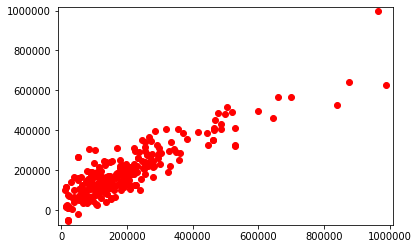

In [50]:
plot_test_predict(X_test, y_predict, y_test)

### Let's try other models!

In [51]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

### Bayesian Ridge with Polynomial Features

In [26]:
from sklearn.linear_model import BayesianRidge
# bayesian ridge worked well-ish
# Crashes for PolynomialFeatures degree 3 though. Not sure why...
bayesian_ridge = make_pipeline(PolynomialFeatures(2), BayesianRidge())
bayesian_ridge.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('bayesianridge',
                 BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                               compute_score=False, copy_X=True,
                               fit_intercept=True, lambda_1=1e-06,
                               lambda_2=1e-06, n_iter=300, normalize=False,
                               tol=0.001, verbose=False))],
         verbose=False)

In [27]:
bayesian_ridge.score(X_test, y_test)

0.8005854820935788

In [28]:
y_predict = bayesian_ridge.predict(X_test)

model_stats(bayesian_ridge,X_test,y_test,X_train,y_train,y_predict)

R^2 for Test Set: 0.8005854820935788
R^2 for Training Set: 0.8655045792254419
RMS error for Test Set: 68650.57821006738
y_test min: 10000
y_test max: 990000
y_test mean: 186814.87889273357
y_predict min: 20184.11559012736
y_predict max: 1203508.446320317
y_predict mean: 183322.34385974592


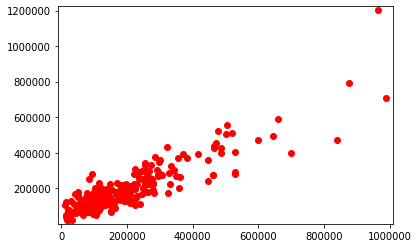

In [29]:
plot_test_predict(X_test, y_predict, y_test)

### Random Forest

In [52]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
forestreg = RandomForestRegressor(n_estimators=100, max_depth=16).fit(X_train, y_train)

In [53]:
y_predict = forestreg.predict(X_test)

model_stats(forestreg,X_test,y_test,X_train,y_train,y_predict)

R^2 for Test Set: 0.8111029709065863
R^2 for Training Set: 0.9705727403431215
RMS error for Test Set: 66815.677547495
y_test min: 10000
y_test max: 990000
y_test mean: 186814.87889273357
y_predict min: 24798.885448916404
y_predict max: 770590.0
y_predict mean: 181458.23554454575


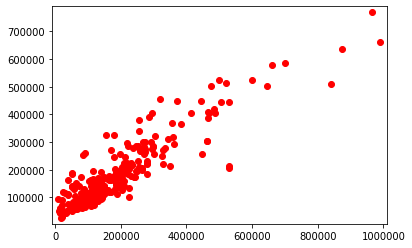

In [54]:
plot_test_predict(X_test, y_predict, y_test)

Even better results than BayesianRidge + polynomial features!

In [55]:
forestreg.feature_importances_

array([1.86294665e-02, 5.64771320e-01, 1.42191587e-02, 1.77492684e-01,
       3.95559034e-03, 1.84483864e-02, 1.43251534e-02, 1.09981306e-02,
       1.05375568e-01, 6.03043314e-03, 1.87496780e-06, 1.04740394e-04,
       9.20815297e-06, 1.46727910e-07, 1.05206986e-05, 8.20804364e-06,
       5.74863528e-07, 2.61440349e-06, 1.09467989e-04, 1.84943891e-05,
       2.32312059e-05, 5.08655879e-05, 9.47882266e-06, 5.90395755e-06,
       6.94944833e-04, 2.38696946e-05, 9.02623568e-06, 1.41234031e-05,
       6.01785456e-06, 2.15387731e-05, 0.00000000e+00, 1.65853991e-04,
       3.42058336e-05, 6.28901820e-05, 6.63651415e-06, 1.32875910e-04,
       9.38761838e-05, 0.00000000e+00, 5.43671756e-04, 2.26471359e-09,
       4.31306231e-05, 2.12788740e-08, 8.79690202e-05, 1.84408677e-04,
       2.42614842e-05, 2.30077914e-04, 5.92984317e-06, 4.60100364e-05,
       7.32337003e-06, 1.52142861e-04, 7.15606515e-04, 3.13408991e-05,
       2.65720337e-05, 3.85361064e-06, 2.00775680e-06, 4.87597081e-05,
      

In [56]:
pd.Series(forestreg.feature_importances_, index=X_test.columns)

land_size                             1.862947e-02
land_value                            5.647713e-01
year_built                            1.421916e-02
sqft_sum                              1.774927e-01
bed_sum                               3.955590e-03
bath_sum                              1.844839e-02
days_ago                              1.432515e-02
main_bldg_year                        1.099813e-02
main_bldg_effective_year              1.053756e-01
room_sum                              6.030433e-03
Sub-4000 DREXEL CONDOMINIUMS          1.874968e-06
Sub-701 HUDSON CONDOMINIUM ESTATES    1.047404e-04
Sub-ADAMS SUB ADDITION                9.208153e-06
Sub-ALBION PLACE ADD                  1.467279e-07
Sub-ALVERA ADDITION                   1.052070e-05
Sub-ALVERA SECOND ADD                 8.208044e-06
Sub-ANDERSONS SUB ADD                 5.748635e-07
Sub-ATKINSONS HI LAND                 2.614403e-06
Sub-AURORA ADDITION                   1.094680e-04
Sub-AVEY & WETZEL              

We notice that land value is very high in feature_importances_. If we remove land value, sure enough, the R^2 and RMS error are worse than polynomial Bayesian or even linear regression (with land value removed). Looks like it might be overfitting, as decision tree/random forest can have a tendency to do...

In [57]:
# RandomForest, no land value

X_train_no_lv = X_train.drop('land_value',axis=1)
X_test_no_lv = X_test.drop('land_value',axis=1)

forestreg_no_lv = RandomForestRegressor(n_estimators=50, max_depth=12).fit(X_train_no_lv, y_train)
y_predict_no_lv = forestreg_no_lv.predict(X_test_no_lv)
model_stats(forestreg_no_lv,X_test_no_lv,y_test,X_train_no_lv,y_train,y_predict_no_lv)

R^2 for Test Set: 0.7076949066934288
R^2 for Training Set: 0.9439810010540297
RMS error for Test Set: 83115.87942789341
y_test min: 10000
y_test max: 990000
y_test mean: 186814.87889273357
y_predict min: 35209.11188514811
y_predict max: 631125.0
y_predict mean: 181458.23554454575


In [39]:
# BayesianRidge, no land value

bayesian_ridge_no_lv = make_pipeline(PolynomialFeatures(2), BayesianRidge()).fit(X_train_no_lv, y_train)
y_predict_no_lv = bayesian_ridge_no_lv.predict(X_test_no_lv)
model_stats(bayesian_ridge_no_lv,X_test_no_lv,y_test,X_train_no_lv,y_train,y_predict_no_lv)

R^2 for Test Set: 0.7729215297313893
R^2 for Training Set: 0.8679610139925251
RMS error for Test Set: 73257.78661916821
y_test min: 10000
y_test max: 990000
y_test mean: 186814.87889273357
y_predict min: -7315.426767170895
y_predict max: 1117574.050722945
y_predict mean: 182285.18740195964


But we see that BayesianRidge can return negative values too! Let's play with parameters anyway with GridSearchCV...

In [40]:
from sklearn.model_selection import GridSearchCV

gsc = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid={
        'max_depth': range(3,20),
        'n_estimators': (10,50,100,500),
    },
    cv=5, scoring="neg_mean_squared_error", verbose=0, n_jobs=-1)
grid_result = gsc.fit(X_train, y_train)

/Users/scoot/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [41]:
grid_result.best_params_

{'max_depth': 18, 'n_estimators': 100}

### MinMaxScaler + Ridge + PolynomialFeatures

In [66]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler


mm_scaler = MinMaxScaler()
X_train_minmax = mm_scaler.fit_transform(X_train)
X_test_minmax = mm_scaler.transform(X_test)


mms_ridge = make_pipeline(PolynomialFeatures(2), Ridge(alpha=2))
mms_ridge.fit(X_train_minmax, y_train)


mms_ridge.score(X_test_minmax, y_test)


0.8023908853183779

In [67]:
y_predict = mms_ridge.predict(X_test_minmax)

model_stats(mms_ridge,X_test_minmax,y_test,X_train_minmax,y_train,y_predict)

R^2 for Test Set: 0.8023908853183779
R^2 for Training Set: 0.9475105096557729
RMS error for Test Set: 68339.10695543041
y_test min: 10000
y_test max: 990000
y_test mean: 186814.87889273357
y_predict min: -28462.317286188292
y_predict max: 1002031.2420712131
y_predict mean: 183452.0031006325


In [68]:
mm_scaler.inverse_transform(X_train_minmax)

array([[4.7916e+03, 2.4353e+04, 1.9120e+03, ..., 1.0000e+00, 0.0000e+00,
        0.0000e+00],
       [7.4052e+03, 2.8852e+04, 1.9850e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [9.5832e+03, 2.0722e+04, 1.9580e+03, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       ...,
       [4.7916e+03, 2.4353e+04, 1.9120e+03, ..., 1.0000e+00, 0.0000e+00,
        0.0000e+00],
       [6.0984e+03, 4.7645e+04, 1.9350e+03, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       [6.9696e+03, 2.8840e+04, 1.9240e+03, ..., 1.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [69]:
X_train

,land_size,land_value,year_built,sqft_sum,bed_sum,bath_sum,days_ago,main_bldg_year,main_bldg_effective_year,room_sum,Sub-4000 DREXEL CONDOMINIUMS,Sub-701 HUDSON CONDOMINIUM ESTATES,Sub-ADAMS SUB ADDITION,Sub-ALBION PLACE ADD,Sub-ALVERA ADDITION,Sub-ALVERA SECOND ADD,Sub-ANDERSONS SUB ADD,Sub-ATKINSONS HI LAND,Sub-AURORA ADDITION,Sub-AVEY & WETZEL,Sub-AVOCA SUB ADDITION,Sub-BALDWIN ESTATES ADD,Sub-BALLARDS ADDITION,Sub-BARBER HEIGHTS SUB,Sub-BAUMANS ADDITION,Sub-BELL VERN ADDITION,Sub-BEVERS SUB ADDITION,Sub-BILLINGTON SUB ADD,Sub-BRAUERS HEIGHTS ADD,Sub-BROADVIEW HEIGHTS,...,Descr-Duplex One half Story,Descr-Duplex Two Story,Descr-Permit Value,Descr-Ranch 1 Story,Descr-Salvage,Descr-Split Level,Descr-Townhouse Multiple Story,Descr-Triplex Multiple Story,Exterior-,Exterior-Frame Aluminum,Exterior-Frame Asbestos,Exterior-Frame Brick Veneer,Exterior-Frame Hardboard,Exterior-Frame Masonry Veneer,Exterior-Frame Permastone,Exterior-Frame Siding,Exterior-Frame Stucco,Exterior-Frame Vinyl,Exterior-High Profile Dome,Exterior-Masonry Concrete Block,Exterior-Masonry Stone,Exterior-Minimal,Exterior-None,Roof-Flat,Roof-Gable,Roof-Gable/Hip,Roof-Gambrel,Roof-Hip,Roof-Hip/Gable,Roof-Mansard
836,4791.6,24353,1912.0,1899.0,4.0,2.50,321,1912.0,2019.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
200,7405.2,28852,1985.0,1264.0,2.0,2.00,209,1985.0,2019.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
351,9583.2,20722,1958.0,1468.0,2.0,1.50,140,1958.0,1958.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
65,8276.4,80171,1936.0,1120.0,2.0,1.00,111,1936.0,2002.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
881,5227.2,16881,1917.0,1202.0,2.0,2.00,149,1917.0,2016.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
773,5662.8,16912,1912.0,1100.0,3.0,1.00,266,1912.0,1912.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
272,6098.4,15498,1950.0,810.0,2.0,1.00,265,1950.0,1994.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
986,6969.6,26040,1928.0,1170.0,2.0,1.00,289,1928.0,1980.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
165,9147.6,35998,1945.0,1426.0,2.0,1.50,71,1945.0,2009.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
683,6098.4,15007,1946.0,1187.0,3.0,1.00,226,1946.0,1968.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Like with linear regression, we again have the issue that some output values turn out to be negative.

### Lasso

In [62]:
from sklearn.linear_model import Lasso

lassoreg = Lasso(positive=True,fit_intercept=True,alpha=2).fit(X_train, y_train)
lassoreg.score(X_test,y_test)

/Users/scoot/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1137720807531.7854, tolerance: 1675990495.5100203
  positive)


0.7624867037860394

In [47]:
y_predict = lassoreg.predict(X_test)
model_stats(lassoreg,X_test,y_test,X_train,y_train,y_predict)

R^2 for Test Set: 0.7624867037860394
R^2 for Training Set: 0.8621314208002208
RMS error for Test Set: 74922.07147287008
y_test min: 10000
y_test max: 990000
y_test mean: 186814.87889273357
y_predict min: -65771.55676375097
y_predict max: 973656.2953160736
y_predict mean: 179555.11521039237


### Preliminary Conclusion

So far, the BayesianRidge regressor appears to be the a good choice. However in some instances it may be prone to returning negative values, which is not acceptable. It may be possible to tweak the parameters to return positive price, or possibly to add an additional step to the pipeline to handle cases of negative value. The effectiveness of these approaches hasn't been evaluated as of yet.

RandomForestRegressor also seems to be a good choice. In some cases it may perform worse than BayesianRidge, but has not exhibited any issues with returning negative values as other regressors have.

### Adding latitude/longitude

Let's import property_centroids.csv, which contains a point (latitude/longitude) to represent each parcel in Oklahoma County.

This was generated by using the esri2geojson tool, part of the esridump pip package, to obtain GIS data from the Oklahoma County Assessor ESRI API (https://oklahomacounty.geocortex.com/arcgis/rest/services/ParcelData/OklahomaCountyAllParcelsData1/MapServer/7/). This contains polygons representing the boundaries of each parcel, in addition to a bunch of other (mostly redundant) data.

The data was loaded into a geopandas GeoDataFrame, and we calculated the centroid of each parcel as to have one point (latitude/longitude) representing each parcel. This data and the account numbers were exported to a CSV file which we will now load.

In [71]:
centroids = pd.read_csv('property_centroids.csv')

In [72]:
centroids

,accountno,lon,lat
0,R264163000,-97.203294,35.685093
1,R168644650,-97.185985,35.648851
2,R168644325,-97.238711,35.642071
3,R168644975,-97.154664,35.641265
4,R168642725,-97.225475,35.670637
5,R168644950,-97.145754,35.641221
6,R168642475,-97.181177,35.684972
7,R168643825,-97.181304,35.655883
8,R168644050,-97.216728,35.656053
9,R168641575,-97.189891,35.713954


In [73]:
merged_df = pd.merge(merged_df, centroids, left_on='account_number', right_on='accountno', how='inner')
included_fields = included_fields + ['lat','lon']
new_df = (merged_df[included_fields][merged_df.price != 0]
          .dropna()
          .reset_index()
          .drop(columns=['index']))

In [74]:
new_df

,land_size,land_value,subdivision,bldg_age,year_built,sqft_sum,bed_sum,bath_sum,price,days_ago,main_bldg_hvac,main_bldg_description,main_bldg_exterior,main_bldg_quality,main_bldg_roof,main_bldg_year,main_bldg_effective_year,room_sum,lat,lon,lat,lon,lat,lon
0,9147.6,48230,DOUGLAS PLACE ADD,68.0,1951.0,1352.0,3.0,1.50,108000,149,Central Air to Air,Ranch 1 Story,Frame Masonry Veneer,Fair,Gable,1951.0,1997.0,6.0,35.522050,-97.521208,35.522050,-97.521208,35.522050,-97.521208
1,9147.6,48230,DOUGLAS PLACE ADD,68.0,1951.0,1352.0,3.0,1.50,108000,202,Central Air to Air,Ranch 1 Story,Frame Masonry Veneer,Fair,Gable,1951.0,1997.0,6.0,35.522050,-97.521208,35.522050,-97.521208,35.522050,-97.521208
2,9147.6,45900,EDGEMERE TERRACE,68.0,1951.0,2018.0,3.0,2.00,305000,237,Central Air to Air,Ranch 1 Story,Frame Masonry Veneer,Fair,Hip,1951.0,2007.0,7.0,35.515214,-97.519994,35.515214,-97.519994,35.515214,-97.519994
3,6969.6,37100,DOUGLAS PLACE ADD,69.0,1950.0,1429.0,2.0,1.75,157000,197,Central Air to Air,Ranch 1 Story,Frame Masonry Veneer,Fair,Gable,1950.0,1970.0,6.0,35.521623,-97.522902,35.521623,-97.522902,35.521623,-97.522902
4,8276.4,42840,EDGEMERE TERRACE,68.0,1951.0,2155.0,3.0,2.00,335000,83,Central Air to Air,Ranch 1 Story,Frame Masonry Veneer,Fair,Hip,1951.0,2007.0,4.0,35.515678,-97.519815,35.515678,-97.519815,35.515678,-97.519815
5,8276.4,42840,EDGEMERE TERRACE,67.0,1952.0,2097.0,3.0,2.50,343500,176,Central Air to Air,Ranch 1 Story,Frame Masonry Veneer,Fair,Hip,1952.0,2010.0,7.0,35.515679,-97.519345,35.515679,-97.519345,35.515679,-97.519345
6,8276.4,42840,EDGEMERE TERRACE,67.0,1952.0,2097.0,3.0,2.50,343500,206,Central Air to Air,Ranch 1 Story,Frame Masonry Veneer,Fair,Hip,1952.0,2010.0,7.0,35.515679,-97.519345,35.515679,-97.519345,35.515679,-97.519345
7,17859.6,85603,EDGEMERE HEIGHTS ADD,67.0,1952.0,2541.0,4.0,2.00,415000,183,Central Air to Air,Ranch 1 Story,Frame Masonry Veneer,Average,Hip,1952.0,2019.0,8.0,35.514866,-97.518660,35.514866,-97.518660,35.514866,-97.518660
8,7405.2,36720,EDGEMERE TERRACE,68.0,1951.0,1416.0,3.0,1.75,182500,259,Central Air to Air,Ranch 1 Story,Frame Masonry Veneer,Fair,Hip,1951.0,2015.0,5.0,35.516010,-97.519365,35.516010,-97.519365,35.516010,-97.519365
9,8276.4,80559,CROWN HEIGHTS ADD,83.0,1936.0,2316.0,4.0,1.75,555000,168,Central Air to Air,1½ Story Fin,Frame Masonry Veneer,Average,Gable,1936.0,2017.0,9.0,35.514304,-97.525810,35.514304,-97.525810,35.514304,-97.525810


Now we have the features we had before, along with the latitude and longitude! Now let's convert the categorical features to one hot encoding and see how it performs.

In [75]:
encoded_dfs = []
encoders = {}
for (col_name, prefix) in encoded_df_names:
    cur_df = return_encoded(new_df, col_name, prefix)
    encoded_dfs.append(cur_df)
    
new_df = new_df.drop(columns=([x[0] for x in encoded_df_names]+[x for x in unused_col_names]))
new_df = pd.concat(([new_df] + [x for x in encoded_dfs]), axis=1)

X = new_df.drop('price',axis=1)
y = new_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Bayesian Ridge w/latlon

In [53]:
from sklearn.linear_model import BayesianRidge
# bayesian ridge worked well-ish
# Crashes for PolynomialFeatures degree 3 though. Not sure why...
bayesian_ridge = make_pipeline(PolynomialFeatures(2), BayesianRidge())
bayesian_ridge.fit(X_train, y_train)

bayesian_ridge.score(X_test, y_test)

y_predict = bayesian_ridge.predict(X_test)

model_stats(bayesian_ridge,X_test,y_test,X_train,y_train,y_predict)

R^2 for Test Set: 0.7930221126739732
R^2 for Training Set: 0.8574284228403974
RMS error for Test Set: 66583.76997944858
y_test min: 500
y_test max: 965000
y_test mean: 191081.27208480565
y_predict min: 9443.751975674939
y_predict max: 1115350.7009879549
y_predict mean: 189098.75933688643


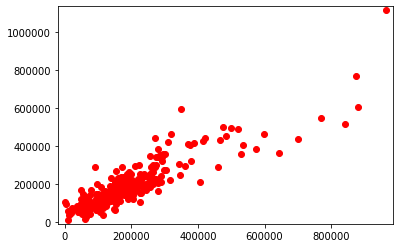

In [54]:
plot_test_predict(X_test, y_predict, y_test)

### Random Forest w/latlon

In [166]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
forestreg = RandomForestRegressor(n_estimators=100, max_depth=16).fit(X_train, y_train)

y_predict = forestreg.predict(X_test)

model_stats(forestreg,X_test,y_test,X_train,y_train,y_predict)

R^2 for Test Set: 0.7118838381732598
R^2 for Training Set: 0.9637394256551469
RMS error for Test Set: 89912.74425208908
y_test min: 500
y_test max: 1750000
y_test mean: 193121.18126272914
y_predict min: 15895.714285714286
y_predict max: 1136530.0
y_predict mean: 188245.24175236747


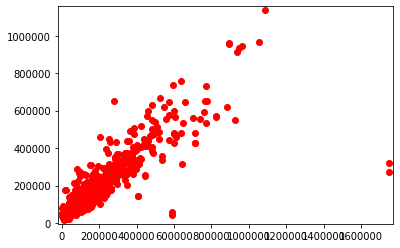

In [167]:
plot_test_predict(X_test, y_predict, y_test)

In both cases, it looks like the R^2 is slightly worse but the RMS error is better than with no lat/lon.

Not totally bad! Let's see what it looks like if we take out the land value like we'd tried before...

### Latlon, no land value

In [79]:
# RandomForest, no land value, with latlon

X_train_no_lv = X_train.drop('land_value',axis=1)
X_test_no_lv = X_test.drop('land_value',axis=1)

forestreg_no_lv = RandomForestRegressor(n_estimators=50, max_depth=17).fit(X_train_no_lv, y_train)
y_predict_no_lv = forestreg_no_lv.predict(X_test_no_lv)
model_stats(forestreg_no_lv,X_test_no_lv,y_test,X_train_no_lv,y_train,y_predict_no_lv)

R^2 for Test Set: 0.8029771024445502
R^2 for Training Set: 0.9650761433650515
RMS error for Test Set: 64962.803284795395
y_test min: 500
y_test max: 965000
y_test mean: 191081.27208480565
y_predict min: 18470.0
y_predict max: 746660.0
y_predict mean: 189155.80615657583


So when we remove the land value but keep the latlon, **the RandomForestRegressor actually does slightly BETTER than in any other case.**

If we can make a good prediction without using the land value (or anything else with a monetary value) as part of X, that would be nice. But if we can make better predictions, that's really awesome!

Let's see what the results from GridSearchCV look like.

In [80]:
from sklearn.model_selection import GridSearchCV

gsc = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid={
        'max_depth': range(3,20),
        'n_estimators': (10,50,100,500),
    },
    cv=5, scoring="neg_mean_squared_error", verbose=0, n_jobs=-1)
grid_result = gsc.fit(X_train, y_train)

grid_result.best_params_

/Users/scoot/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_depth': 15, 'n_estimators': 50}

Let's try BayesianRidge now.

In [121]:
# BayesianRidge, no land value, with latlon

bayesian_ridge_no_lv = make_pipeline(PolynomialFeatures(2), BayesianRidge()).fit(X_train_no_lv, y_train)
y_predict_no_lv = bayesian_ridge_no_lv.predict(X_test_no_lv)
model_stats(bayesian_ridge_no_lv,X_test_no_lv,y_test,X_train_no_lv,y_train,y_predict_no_lv)

R^2 for Test Set: 0.7197596175701764
R^2 for Training Set: 0.8180575757841588
RMS error for Test Set: 83259.85909847547
y_test min: 500
y_test max: 1945000
y_test mean: 186343.5270132518
y_predict min: -52344.99950777739
y_predict max: 3434066.145175852
y_predict mean: 189520.2099340099


BayesianRidge doesn't do so well in this case. From what it looks like, the RandomForestRegressor with latlon and with no land value is the way to go!

### playing with ridge/lasso some more

In [76]:
lassoreg = Lasso(positive=True,fit_intercept=True,alpha=2).fit(X_train, y_train)
lassoreg.score(X_test,y_test)

/Users/scoot/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1126227253741.0164, tolerance: 1647905356.0908
  positive)


0.7126838290523707

In [77]:
mm_scaler = MinMaxScaler()
X_train_minmax = mm_scaler.fit_transform(X_train)
X_test_minmax = mm_scaler.transform(X_test)


mms_ridge = make_pipeline(PolynomialFeatures(2), Ridge(alpha=2))
mms_ridge.fit(X_train_minmax, y_train)


mms_ridge.score(X_test_minmax, y_test)

0.7699096093524085

In [78]:
y_predict = mms_ridge.predict(X_test_minmax)

model_stats(mms_ridge,X_test_minmax,y_test,X_train_minmax,y_train,y_predict)

R^2 for Test Set: 0.7699096093524085
R^2 for Training Set: 0.9603677473389234
RMS error for Test Set: 70202.99609864768
y_test min: 500
y_test max: 965000
y_test mean: 191081.27208480565
y_predict min: 1525.6892155001115
y_predict max: 989023.2272122218
y_predict mean: 189155.80615657583
